# Find, visualize, organize and export hypertension participant data

> Scope: Building on **Notebook 105** we will retrieve, visualise and organise phenotypic data for high blood pressure studies 

**Note: This notebook will fail on datasets dispensed before November 30 2023 (data v17.1) due to a change in the data structure for the 'Non-cancer illness, self reported' field. To get an updated version of the data, please dispense a new RAP project.**

Run info:

- runtime: 20min 
- recommended instance: mem1_ssd1_v2_x16
- estimated cost: <£0.30

This notebook depends on:
* **A Spark instance**

This notebook is a more advanced version of notebook **105** "Export participant data to R". In addition to fetching phenotypic data, we will investigate how to work with different sources and types of phenotypic data. The goal is to retrieve phenotypic annotations that we will use to perform GWAS (notebook **204**) and PRS (notebook **206**) studies of hypertension. We will use three sources:

- Non-cancer illness code, self-reported
- Diagnoses - ICD10
- Underlying (primary) cause of death
- Blood pressure measurement during the interview (systolic and diastolic)

Next, we will examine and visualize the data – the empirical probability densities for systolic and diastolic blood pressures for self-reported hypertension vs. non-affected and systolic and diastolic as scatter plots with the colour-coded condition. We will also apply CDC blood pressure level cut-offs to find which patients measured above the high blood pressure (hypertension) threshold during the interview. Next, we will visualise the overlap between these three sources of information (self-reported, ICD10 diagnoses and diastolic blood pressure) on the Venn diagram. Finally, we will prepare tabular file formats that will be input for further analyses.

## Install required packages

Function `p_load` from `pacman` loads packages into R.
If the given package is missing `p_load` will automatically install it - this can take a considerable amount of time for a package that needs C or FORTRAN code compilation.
The following packages are needed to run this notebook:

- `reticulate` - R-Python interface, required to use `dxdata` package that connects to Spark database and allows retrieval of phenotypic data 
- `dplyr` - tabular data manipulation in R, require to pre-process, encode and filter phenotypic data
- `parallel` - parallel computation in R
- `arrow` - input/output library for Apache binary files
- `skimr` - provide summary statistics about variables in data frames, tibble objects, data tables and vectors
- `VennDiagram` - visualise set overlaps as Venn diagrams
- `grid` - convert VennDiagram outputs to grid objects and plot Venn diagrams in the notebook output
- `scales` - add opacity/colour overlay effect to Venn diagrams

In [1]:
#Load required packages
if(!require(pacman)) install.packages("pacman")
pacman::p_load(reticulate, dplyr, parallel, skimr, VennDiagram, grid, scales, ggplot2, readr, arrow)

Loading required package: pacman



## Import dxdata package, initialize Spark (dxdata) engine and connect to the dataset

Next, we set a `DATASET_ID` variable, which takes a value: `[projectID]:[dataset ID]`
We use it to define the `dataset` with `dxdata.load_dataset` function.

**projectID** and **dataset ID** values are unique to your project.
Notebook example **101** explains how to get them.



In [2]:
dxdata <- import("dxdata")
project <- Sys.getenv('DX_PROJECT_CONTEXT_ID')
record <- system("dx find data --type Dataset --delimiter ',' | awk -F ',' '{print $5}'" , intern = TRUE)
DATASET_ID <- paste0(project, ":", record)
dataset <- dxdata$load_dataset(id=DATASET_ID)

##  Select the `participant` 

The following code selects the `participant` table.

In [3]:
pheno <- dataset$entities_by_name[['participant']]

## Select fields from `participant` table


We can define which field we are interested in using the `find_field` function.

In this example we use the following ways to define the fields:

- With the `name` argument: here we give field ID. We can construct the field ID used by the `dxdata` package from the field ID defined by UKB Showcase. The numeric showcase ID is translated to the Spark DB column name by adding the letter `p` at the beginning: e.g. *Standing height* showcase id is `50`, so Spark ID would be `p50`. Usually, fields have multiple instances. In such case, we add `_i` suffix followed by instance number, e.g. *Standing height | Instance 0* will be `p50_i0`. Fields can also have multiple arrays if, for example, more than one measurement or answer was given. These are indicated by an `_a` suffix followed by the array number, e.g. *Diastolic blood pressure, automated reading | Instance 0 | Array 0* will be `p4079_i0_a0`. 
- With `title` argument: here we define the field by full title, followed by ` | Instance` suffix, e.g. `Age at recruitment` or `Standing height | Instance 0`.

We can also use the `find_fields` function to find multiple fields.

- In this example we use the `title_regex` argument to define the fields with a regular expression found in the field title. The example below will find all fields with a title containing `Non-cancer illness code, self-reported | Instance 0` i.e. all arrays for Instance 0. Individual field titles will be e.g. `Non-cancer illness code, self-reported | Instance 0 | Array 0`. Note that we use `\\` to escape the special character `|` in the regex.
- Other arguments available to use include `names` - a list of field names as above, `titles` - a list of field titles as above, and `name_regex` - a regular expression for field names.

The data dictionary may be helpful in finding field names and titles. The data dictionary can be generated by running `system(paste0("dx extract_dataset ", DATASET_ID, " -ddd"))` in R, or `dx extract_dataset <DATASET_ID> -ddd` in the command line.
More information on field IDs, instances and arrays for each field is available on the [UK Biobank Showcase](https://biobank.ndph.ox.ac.uk/showcase/).  

In [4]:
fld = c(
    pheno$find_field(name="eid"),
    iterate(pheno$find_fields(title_regex = "Non-cancer illness code, self-reported \\| Instance 0")),
    pheno$find_field(title="Diagnoses - ICD10"),
    pheno$find_field(title="Underlying (primary) cause of death: ICD10 | Instance 0"),
    pheno$find_field(name="p4079_i0_a0"),
    pheno$find_field(name="p4079_i0_a1"),
    pheno$find_field(name="p4080_i0_a0"),
    pheno$find_field(name="p4080_i0_a1")
)

## Preview a list of fields 

In [5]:
str(fld)

List of 41
 $ :<Field "eid">
 $ :<Field "p20002_i0_a0">
 $ :<Field "p20002_i0_a1">
 $ :<Field "p20002_i0_a2">
 $ :<Field "p20002_i0_a3">
 $ :<Field "p20002_i0_a4">
 $ :<Field "p20002_i0_a5">
 $ :<Field "p20002_i0_a6">
 $ :<Field "p20002_i0_a7">
 $ :<Field "p20002_i0_a8">
 $ :<Field "p20002_i0_a9">
 $ :<Field "p20002_i0_a10">
 $ :<Field "p20002_i0_a11">
 $ :<Field "p20002_i0_a12">
 $ :<Field "p20002_i0_a13">
 $ :<Field "p20002_i0_a14">
 $ :<Field "p20002_i0_a15">
 $ :<Field "p20002_i0_a16">
 $ :<Field "p20002_i0_a17">
 $ :<Field "p20002_i0_a18">
 $ :<Field "p20002_i0_a19">
 $ :<Field "p20002_i0_a20">
 $ :<Field "p20002_i0_a21">
 $ :<Field "p20002_i0_a22">
 $ :<Field "p20002_i0_a23">
 $ :<Field "p20002_i0_a24">
 $ :<Field "p20002_i0_a25">
 $ :<Field "p20002_i0_a26">
 $ :<Field "p20002_i0_a27">
 $ :<Field "p20002_i0_a28">
 $ :<Field "p20002_i0_a29">
 $ :<Field "p20002_i0_a30">
 $ :<Field "p20002_i0_a31">
 $ :<Field "p20002_i0_a32">
 $ :<Field "p20002_i0_a33">
 $ :<Field "p41270">
 $ :<Fie

## Now define the Spark engine

In [6]:
engine <- dxdata$connect(dialect="hive+pyspark")
engine

Engine(hive+pyspark:///)

## Retrieve the fields defined in `fld` list

In [7]:
df <- pheno$retrieve_fields(engine=engine, fields=fld, coding_values="replace")

## Now write the data to a temporary `parquet`file 

You can learn more about *parquet* file format here: [https://parquet.apache.org/](https://parquet.apache.org/)

In [8]:
system('hadoop fs -rm -r -f tmpdf.parquet', intern = TRUE)
df$write$parquet('tmpdf.parquet')

[1] "Deleted tmpdf.parquet"

## Convert and copy the temporary `parquet` file from a distributed format to the local file system

In [9]:
system('hdfs dfs -ls', intern = TRUE)

[1] "Found 1 items"                                                           
[2] "drwxr-xr-x   - root supergroup          0 2024-09-16 14:55 tmpdf.parquet"

In [10]:
if(dir.exists('tmpdf.parquet')) unlink("tmpdf.parquet", recursive=TRUE)
system('hadoop fs -copyToLocal tmpdf.parquet', intern = TRUE)

character(0)

## Read the dataset information R using Apache `arrow` package

In [11]:
ds <- arrow::open_dataset('tmpdf.parquet')

## Collect the data from the dataset to R memory

Now, the phenotypic data are available as standard `tibble` objects, which can be interacted with using methods from `tidyverse` environment.

In [12]:
tbl <- ds %>% collect

## Count individuals with self-reported hypertension 

In [13]:
tbl %>% filter(if_any(starts_with('p20002'), ~ . == 'hypertension')) %>% nrow

[1] 130922

## Count individuals with ICD10 diagnoses for hypertension 

In [14]:
tbl %>% filter(sapply(p41270, function(x) is.element("I10 Essential (primary) hypertension", x))) %>% nrow

[1] 162270

## Count individuals with hypertension as an underlying (primary) cause of death

In [15]:
tbl %>% filter(sapply(p40001_i0, function(x) is.element("I10 Essential (primary) hypertension", x))) %>% nrow

[1] 38

## Add logical (true/false) columns for self-reported and ICD10 diagnoses hypertension

In [16]:
tbl2 <- tbl %>% 
    mutate(sd=if_any(starts_with('p20002'), ~ . %in% 'hypertension')) %>% 
    mutate(md=sapply(p41270, function(x) is.element("I10 Essential (primary) hypertension", x))) 

# Systolic and diastolic blood pressure levels cutoffs

We will use the following Blood Pressure Levels (as defined by CDC):

- Normal
  - systolic: less than 120 mm Hg 
  - diastolic: less than 80 mm Hg
At-Risk (pre-hypertension)
  - systolic: 120–139 mm Hg 
  - diastolic: 80–89 mm Hg
- High Blood Pressure (hypertension)
  - systolic: 140 mm Hg or higher 
  - diastolic: 90 mm Hg or higher

### Count individuals above High Blood Pressure (hypertension) cutoff

In [17]:
table(tbl$p4079_i0_a0 >= 90 & tbl$p4080_i0_a0 >= 140)


 FALSE   TRUE 
370187  97574 

## Add logical (true/false) columns for high systolic and diastolic blood pressure levels

In [18]:
tbl2 <- tbl2 %>% 
    mutate(id = p4079_i0_a0 >= 90 & p4080_i0_a0 >= 140)

## Visualise phenotypic data

#### Construct a list for a Venn diagram 

In [21]:
venn_list <- list(
    'Self\nreported' = tbl2 %>% filter(sd)  %>% pull(eid),
    'Medical\nrecords' = tbl2 %>% filter(md)  %>% pull(eid),
    'Blood pressure\ncutoff' = tbl2 %>% filter(id)  %>% pull(eid)
)

In [22]:
as.data.frame(lengths(venn_list))

,lengths(venn_list)
,<int>
Self reported,130922
Medical records,162270
Blood pressure cutoff,97574


#### Plot the Venn diagram 

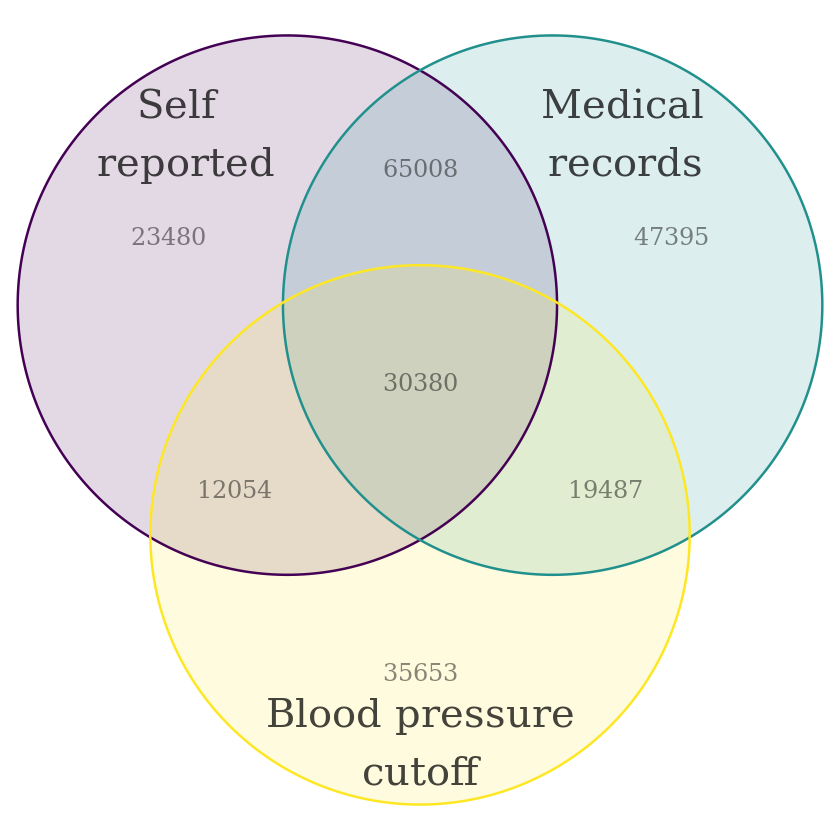

In [23]:
vd <- venn.diagram(
    x = venn_list, 
    filename = NULL,
    col=c("#440154ff", '#21908dff', '#fde725ff'),
    fill = c(alpha("#440154ff",0.3), alpha('#21908dff',0.3), alpha('#fde725ff',0.3)),
    cex = 1.2,
    cat.cex = 2.0,
    cat.default.pos = "text",
    cat.col=c("#000000BB"),
    label.col = c("#00000077"),
    cat.dist=c(0.0,0,0),
    cat.just=list(c(.4,-.7), c(.8,-.7), c(.5,1.3))
)
grid.draw(vd)

#### Plot the systolic blood pressure measurements distributions for the self-reported hypertension field

Warning message:
“Removed 34430 rows containing non-finite outside the scale range
(`stat_density()`).”


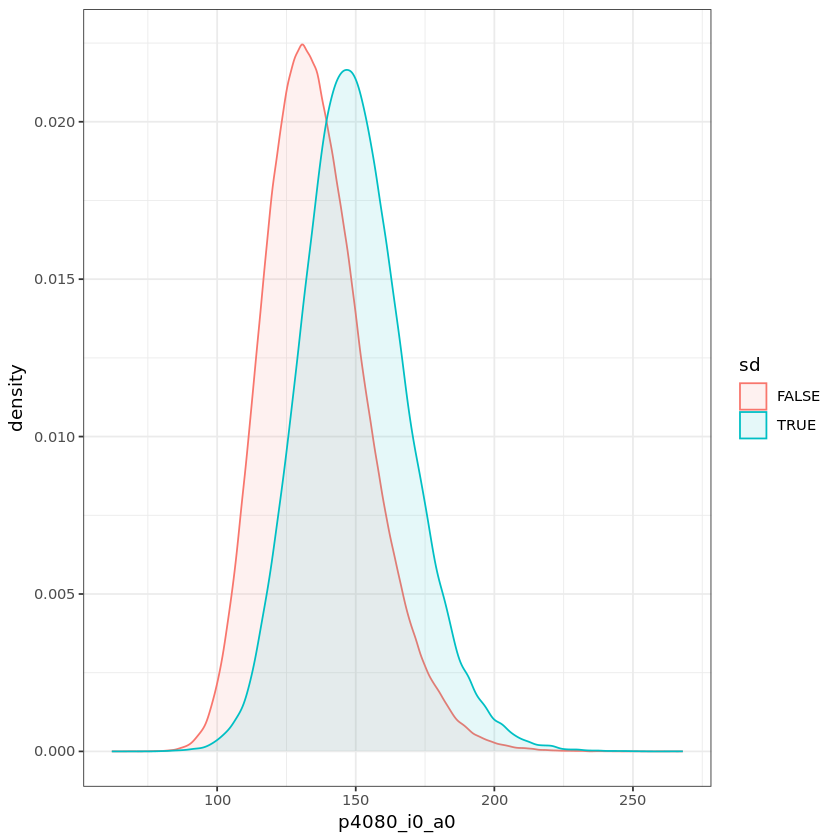

In [24]:
ggplot(tbl2, aes(p4080_i0_a0 , colour = sd, fill =sd)) + 
  geom_density(alpha = 0.1) +
  theme_bw()

#### Plot the diastolic blood pressure measurements distributions for the self-reported hypertension field

Warning message:
“Removed 34417 rows containing non-finite outside the scale range
(`stat_density()`).”


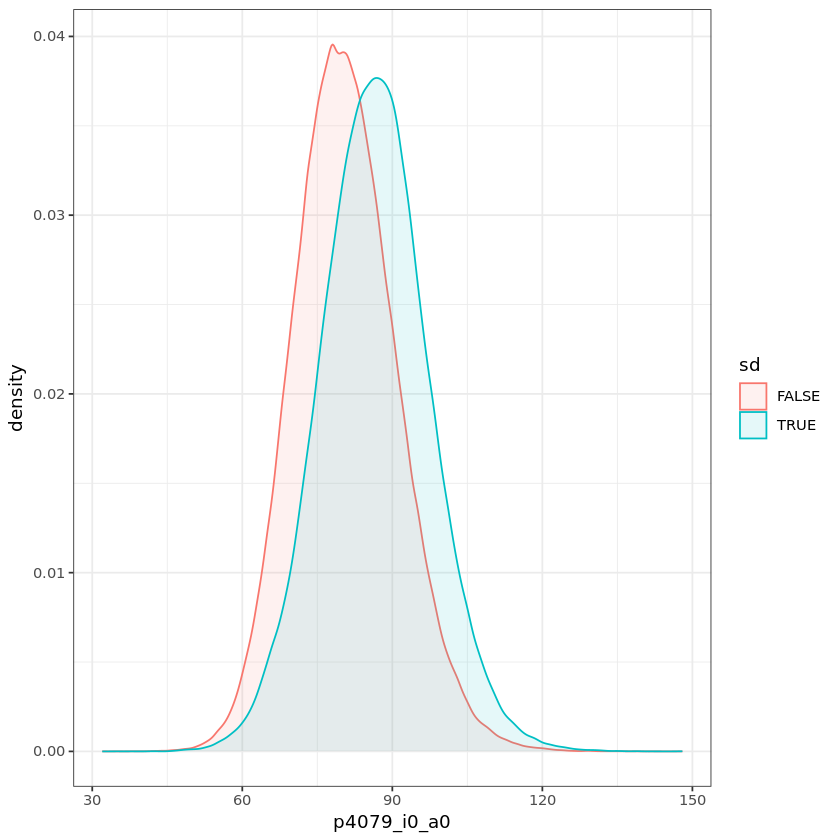

In [25]:
ggplot(tbl2, aes(p4079_i0_a0 , colour = sd, fill =sd)) + 
  geom_density(alpha = 0.1) +
  theme_bw()

#### Plot the systolic and diastolic blood pressure measurements as multivariate distribution
- black lines represent CDC hypertension cutoffs
- colour coding represents self-reported hypertension field

Warning message:
“Removed 34430 rows containing missing values or values outside the scale range
(`geom_point()`).”


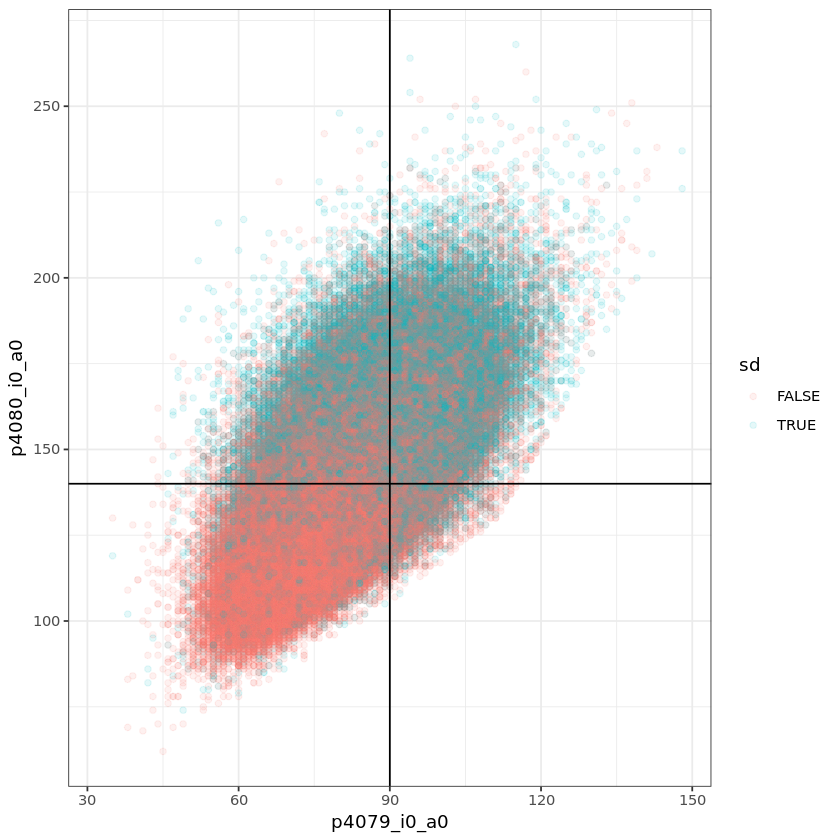

In [26]:
ggplot(tbl2, aes(p4079_i0_a0 , p4080_i0_a0 , colour = sd, fill =sd)) + 
  geom_point(alpha = 0.1) +
  geom_hline(yintercept = 140) +
  geom_vline(xintercept = 90) +
  theme_bw()

## Export data to CSV file

In [27]:
tbl_export <- tbl2 %>% select(-p41270, -starts_with('p20002'), -p40001_i0)

In [28]:
colnames(tbl_export) <- c('eid', 'systolic_a0', 'systolic_a1', 'diastolic_a0', 'diastolic_a1', 'self_reported', 'medical_records', 'blood_pressure_cutoff')

In [29]:
write_csv(tbl_export, 'pheno_data_hypertension.csv')

## Upload the data to your project 

We will refer to this file in notebook **204**. \
Another option is to use the [Table exporter](https://dnanexus.gitbook.io/uk-biobank-rap/working-on-the-research-analysis-platform/accessing-phenotypic-data-as-a-file).

In [30]:
#If necessary create the folder....
system("dx mkdir pheno")
#....then upload
system("dx upload pheno_data_hypertension.csv --path pheno/")